# Personal Spotify Analysis

I chose to do this anaylsis because I wanted to learn more about utilizing and troubleshooting APIs and working with JSON files. Additionally, I felt looking at my personal spotify account would allow for some interesting analysis to see the evolution of my muscial tastes through time.

In [1]:
import sys
import spotipy
import spotipy.util as util
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
%matplotlib inline
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import SpectralClustering
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

### Authentication of my account

Through spotify's web developer portal, it is very easy to get quickly authenticated for building both commercial and non-commercial apps. Upon being approved, you are generated an ID along with Secret ID. I saved these keys through the command line so they are not referenced here.

In [2]:
username = sys.argv[1]

In [3]:
token = util.prompt_for_user_token(username,scope = 'user-top-read')

In [4]:
sp = spotipy.Spotify(auth=token)

### My Current Top Artists with Clustering Analysis

In [5]:
genre_dic = defaultdict(int)
offset = [0,20,40,60,80,100,120,140,160,180]

In [6]:
for offset_val in offset:
    artists_med = sp.current_user_top_artists(offset=offset_val)
    for i in range(len(artists_med['items'])):
        for item in artists_med['items'][i]['genres']:
            genre_dic[item] += 1

I now have a dictionary full of all the different genres of my top 200 artists. I'd like to take a look at these and group similar genres so I can get a more broad understanding of the overarching genres I'm listening to. I'll preform a TFIDF weighting to vectorize the genres to allow for comparison. Due to the fact that many/all of these genres are only 1-3 words, this isn't going to be the most effective measure for comparing the similarity or using TF-IDF. That being said, from glancing at the genres, it did appear that many of the 2 and 3 word genres had words like 'pop' or 'country' or 'rock' that could be tied to other words and could match well.

In [7]:
corpus = genre_dic.keys()                                                                                                       
vect = TfidfVectorizer(min_df=1)            
tfidf = vect.fit_transform(corpus)
pairwise_similarity = np.asmatrix((tfidf * tfidf.T).toarray())

Now that I have the matrix of TFIDF scores, I can doing clustering to see what the trends are behind the data. I'm choosing to only look at 3 different clusters for the time being just because I don't believe I have that wide a variety 

In [8]:
mapping = SpectralClustering(3).fit_predict(pairwise_similarity)

In [9]:
clusterings = pd.DataFrame(data = {'genre': list(genre_dic.keys()), 'mapping': mapping})

In [10]:
concat_genre_zero = ' '.join([f for f in clusterings[clusterings['mapping'] == 0]['genre']])
concat_genre_one = ' '.join([f for f in clusterings[clusterings['mapping'] == 1]['genre']])
concat_genre_two = ' '.join([f for f in clusterings[clusterings['mapping'] == 2]['genre']])

This is most expansive group in the cluster and contains my favorite genres. I listen to a lot of folk, country, americana and this group encompasses that a lot more.

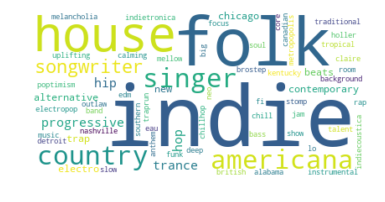

In [11]:
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(concat_genre_zero)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The first group appears to be a rock, indie, alternative, garage, genre. It has a signficantly smaller population than the other two groups which makes sense. I don't listen to a ton of rock and alternative music but they often times do share a word like 'rock'

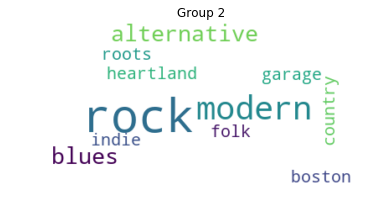

In [17]:
wordcloud = WordCloud(max_font_size=55, max_words=100, background_color="white").generate(concat_genre_one)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Group 2')
plt.show()

I was expecting there to be one group that felt out of place and would not have a consistent theme. Due to the data I used only including at most 3 words, it was inevitable. It makes sense that all the one word genres 'pop', 'rap', 'dance', etc.. got paired together and that is this grouping

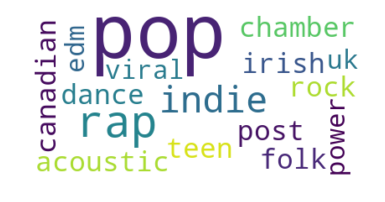

In [18]:
wordcloud = WordCloud(max_font_size=90, max_words=100, background_color="white").generate(concat_genre_two)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

By default, the API call looks at a 'medium' date range. I want to now take a look to see how the medium range compares to my short term and long term preferences.

In [19]:
artist_dic = defaultdict(int)
offset2 = [0,20,40,60,80,100,120,140,160,180]
term = ['short_term','medium_term','long_term']

In [20]:
for offset_val in offset2:
    for term_val in term:
        artists = sp.current_user_top_artists(offset=offset_val, time_range=term_val)
        for i in range(len(artists['items'])):
            artist_dic[(artists['items'][i]['name'])] += 1

In [21]:
arts = []
vals = []
for a,b in sorted(artist_dic.items(), key=lambda x: x[1], reverse=True):
    arts.append(a)
    vals.append(b)

No handles with labels found to put in legend.


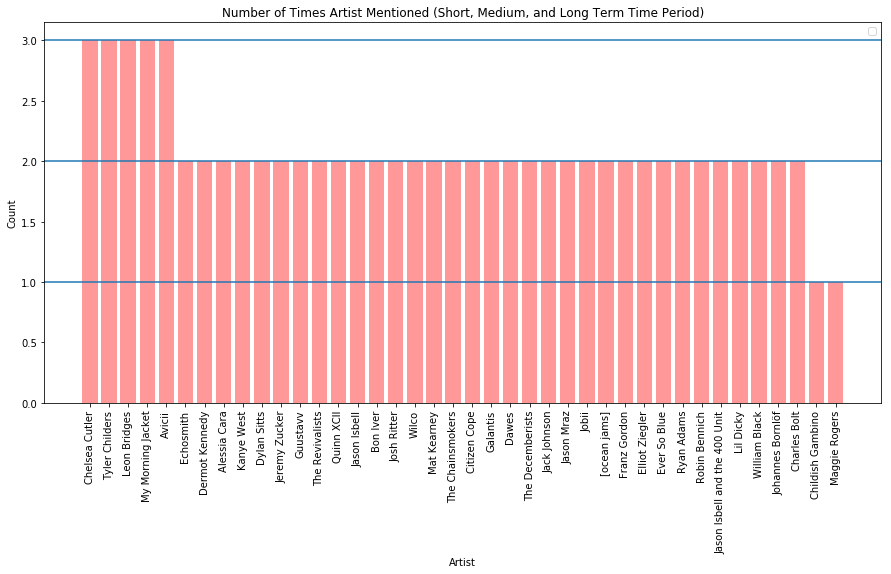

In [23]:
f, ax = plt.subplots(1, 1, figsize = (15, 7))
ax.bar(arts[:40],vals[:40], color='red', alpha=0.4)
plt.title('Number of Times Artist Mentioned (Short, Medium, and Long Term Time Period)')
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Count')
plt.axhline(3)
plt.axhline(2)
plt.axhline(1)
plt.legend()
plt.show()

### Recently Played

I'm interested in taking a look into what I've been listening to recently. Through spotify's API, I can look at the past 50 tracks I've listened to. In order to categorize it better, I've stored it in a dictionary.

In [24]:
token = util.prompt_for_user_token(username,scope = 'user-read-recently-played')
sp1 = spotipy.Spotify(auth=token)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=96b658e2c3944ac2bcc51b53b164032e&response_type=code&redirect_uri=http%3A%2F%2Fgoogle.com%2F&scope=user-read-recently-played in your browser


Enter the URL you were redirected to: https://www.google.com/?code=AQDK_lp9TgmnXa-SHB7SiSFHWqoxXZ8QNOugFxWVUD_36zefMzs_MPAhIC0ec2rKnmHkvVRTw0LKCe-WbzxMTeYD50Pb22oBeHxhklQsCzTR3nf7tr0uh1lHEaTIUx53FpqUa5L4ygTlYS2oEZb2FCDJXCzYNDeJfusHnkUNEFvT7gJjNEsJXRgsNP7-kkgcWHvtnZX35zOjyxxBf7ieL6otug




In [25]:
recently_played = sp1.current_user_recently_played(limit = 50)

In [26]:
played_time = [recently_played['items'][i]['played_at'] for i in range(len(recently_played['items']))]

In [27]:
from collections import defaultdict
recent_artist_dic = defaultdict(int)

In [28]:
for i in range(len(recently_played['items'])):
    recent_artist_dic[recently_played['items'][i]['track']['artists'][0]['name']] += 1

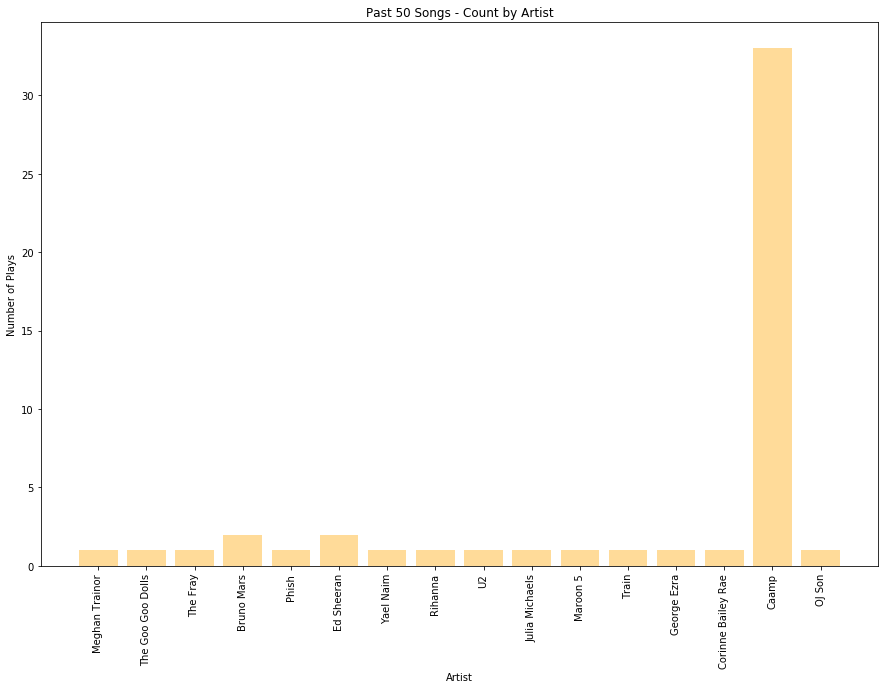

In [29]:
f, ax = plt.subplots(1, 1, figsize = (15, 10))
ax.bar(recent_artist_dic.keys(),recent_artist_dic.values(), color='orange', alpha=0.4)
plt.title('Past 50 Songs - Count by Artist')
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Number of Plays')
plt.show()